# Crossref pipeline

We have a simple task, we want to retireve a list of papers that is close to the universe of papers for a particular search string (using the paper title). We are going to use Crossref data and use it to query and get the publication DOIs and download the corresponding PDFs when is possible (we're doing low-key a crime here by using SciHub as a source of PDFs, but more on that later). 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import duckdb
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from pathlib import Path
from IPython.display import HTML

con = duckdb.connect(database="../crossref_database.db", read_only=False)

/home/topcat/miniforge3/envs/lit_review/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Find papers

In [3]:
con = duckdb.connect(database="../crossref_database.db")

In [15]:
from adaptation_reviewer.process import create_table

table_papers = create_table(
    path_parquet="/mnt/drive/lit_review_data/crossref_parquet_flatten",
    keyords=["adaptation", "mortality", "temperature"],
    table_name="test",
    create_table=False,
    db_name="../crossref_database.db",
)

In [20]:
table_papers[table_papers.title.str.contains("Valuing")].head()

,uuid,doi,title,first_author,year,abstract
338,62d55bd9ff,10.1093/qje/qjac020,Valuing the Global Mortality Consequences of C...,"Carleton, Tamma",2022,"Using 40 countries’ subnational data, we estim..."


In [5]:
embed_df = con.sql(
    """
select a.uuid, a.title, a.first_author, e.embeddings
from adaptation_mortality a 
join adaptation_mortality_embed_abstracts e 
on a.uuid = e.id
"""
).to_df()

embed_echo_lab = con.sql(
    """
select a.uuid, a.title, a.author, e.embeddings
from echolab a 
join echolab_embed_abstracts e 
on a.uuid = e.id
"""
).to_df()

### Understand embeddings using tSNE

In [6]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(random_state=42, n_iter=1000, metric="cosine")
embeddings2d = tsne.fit_transform(np.vstack(embed_df.embeddings.values))
embeddings2d_echo = tsne.fit_transform(
    np.vstack(embed_echo_lab.embeddings.values)
)

embed_df = embed_df.assign(x=embeddings2d[:, 0], y=embeddings2d[:, 1])
embed_echo_lab = embed_echo_lab.assign(
    x=embeddings2d_echo[:, 0], y=embeddings2d_echo[:, 1]
)

/home/topcat/miniforge3/envs/lit_review/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/home/topcat/miniforge3/envs/lit_review/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


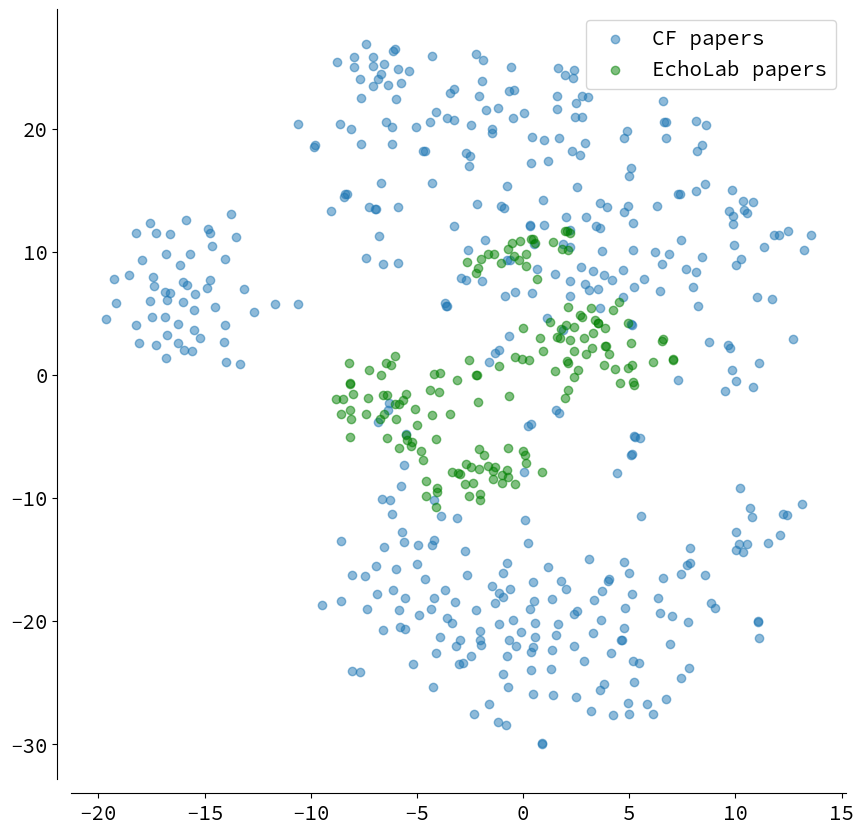

In [7]:
# Set up font and font size for plots
plt.rcParams["font.family"] = "Source Code Pro"
plt.rcParams["font.size"] = 15

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(embed_df.x, embed_df.y, alpha=0.5)
ax.scatter(embed_echo_lab.x, embed_echo_lab.y, alpha=0.5, color="green")

# Add legend to plot
ax.legend(["CF papers", "EchoLab papers"], loc="upper right")

# Remove the top and right spines from plot
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Despine the plot to remove origin
ax.spines["left"].set_position(("outward", 10))
ax.spines["bottom"].set_position(("outward", 10))

In [8]:
embed_df[embed_df.title.str.contains("Fluct")]

,uuid,title,first_author,embeddings,x,y
143,e2ec91f466,"Climate Change, Mortality, and Adaptation: Evi...","Deschênes, Olivier","[-0.033173665, 0.016535599, -0.00036426785, 0....",-5.566877,-20.658005


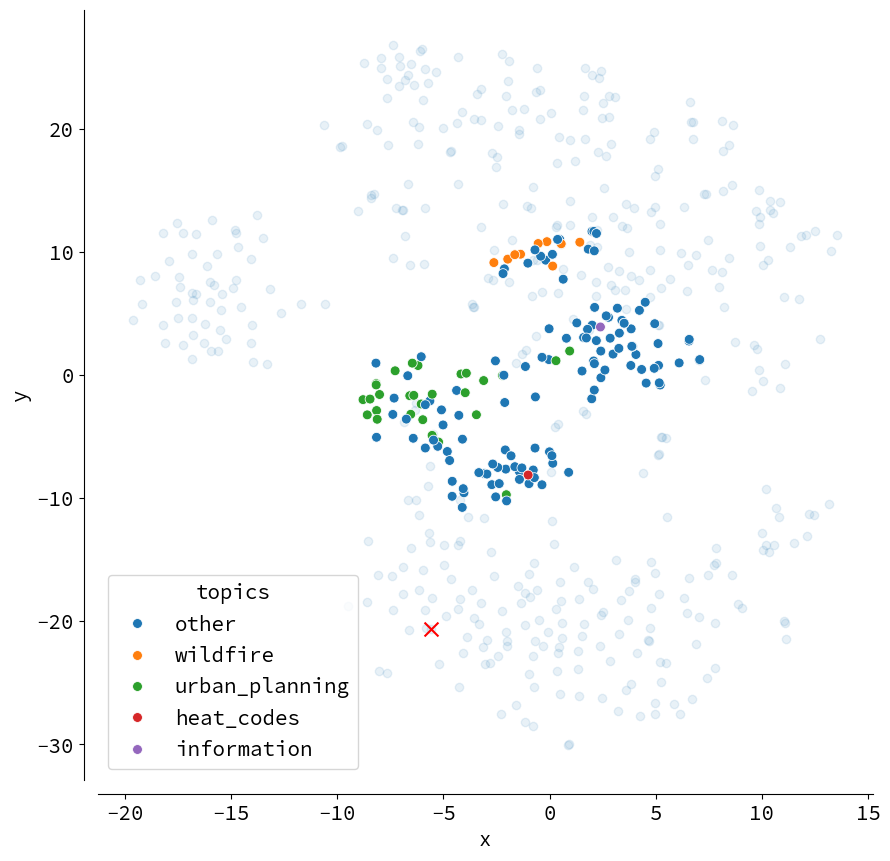

In [9]:
import seaborn as sns

# How does stuff looks by topic?
cats = {
    "heat_codes": embed_echo_lab.title.str.contains("codes | regulation"),
    "urban_planning": embed_echo_lab.title.str.contains(
        "urban | space | trees"
    ),
    "information": embed_echo_lab.title.str.contains("alert | information"),
    "wildfire": embed_echo_lab.title.str.contains("wildfire | smoke"),
}

embed_echo_lab["topics"] = np.select(
    cats.values(), cats.keys(), default="other"
)

# Set up font and font size for plots
plt.rcParams["font.family"] = "Source Code Pro"
plt.rcParams["font.size"] = 15

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(embed_df.x, embed_df.y, alpha=0.1)
sns.scatterplot(data=embed_echo_lab, x="x", y="y", hue="topics", ax=ax, s=50)

embed_df[embed_df.uuid == "e2ec91f466"].plot.scatter(
    x="x", y="y", ax=ax, marker="x", s=100, color="red"
)

# Remove the top and right spines from plot
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Despine the plot to remove origin
ax.spines["left"].set_position(("outward", 10))
ax.spines["bottom"].set_position(("outward", 10))

### Search for close buddies and do a sample QA 

In [12]:
con.execute(
    """
    INSTALL vss; 
    LOAD vss; 
    SET GLOBAL hnsw_enable_experimental_persistence = true;
    """
)

# con.execute(
#     """
#     DROP INDEX IF EXISTS my_hnsw_index;
#     --CREATE INDEX my_hnsw_index ON adaptation_mortality_embed_abstracts USING HNSW (embeddings);
#     """
# )

In [13]:
# Ask question to retrieve records
embedding_model_type = "all-mpnet-base-v1"
embedding_model = SentenceTransformer(embedding_model_type)
embeddings = embedding_model.encode(
    "Causal or experimental evidence of adaptation to temperature mortality",
    show_progress_bar=True,
)

embed_size = embeddings.shape[0]

Batches: 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]


In [14]:
from duckdb.typing import VARCHAR


def embed(sentence: str) -> np.ndarray:
    return embedding_model.encode(sentence)


con.create_function("embed_qa", embed, [VARCHAR], "FLOAT[768]")


def search(q: str):
    return con.execute(
        """
        from adaptation_mortality_embed_abstracts as e 
        join adaptation_mortality as m 
        on (m.uuid = e.id) 
        select 
        m.uuid,
        m.title, 
        m.first_author, 
        m.year, 
        array_cosine_similarity(e.embeddings, embed_qa($q)) as cos_sim, 
        order by cos_sim desc;
        """,
        {"q": q},
    ).df()

In [15]:
df_search = search(
    "Causal or experimental evidence of adaptation to the effects of temperature on mortality"
)
df_search.head()

,uuid,title,first_author,year,cos_sim
0,9d020fa03e,Winter mortality in a warming climate: a reass...,"Ebi, Kristie L.",2013,0.715725
1,d5bcd9e893,Convergence in Adaptation to Climate Change: E...,"Barreca, Alan",2015,0.693406
2,dc8575b525,Heat Adaptation among the Elderly in Spain (19...,"Navas-Martín, Miguel Ángel",2023,0.677222
3,7ea41704b5,Evidence of Adaptation to Increasing Temperatures,"Weitensfelder, Lisbeth",2019,0.675954
4,69f308965a,Countrywide analysis of heat- and cold-related...,"Janoš, Tomáš",2023,0.674658


In [ ]:
# e2ec91f466, 62d55bd9ff
embed_df[embed_df.title.str.contains("Valuing")]

,uuid,title,first_author,embeddings,x,y
265,62d55bd9ff,Valuing the Global Mortality Consequences of C...,"Carleton, Tamma","[-0.027187776, 0.046290964, 0.016934723, 0.010...",-0.927178,-17.859718


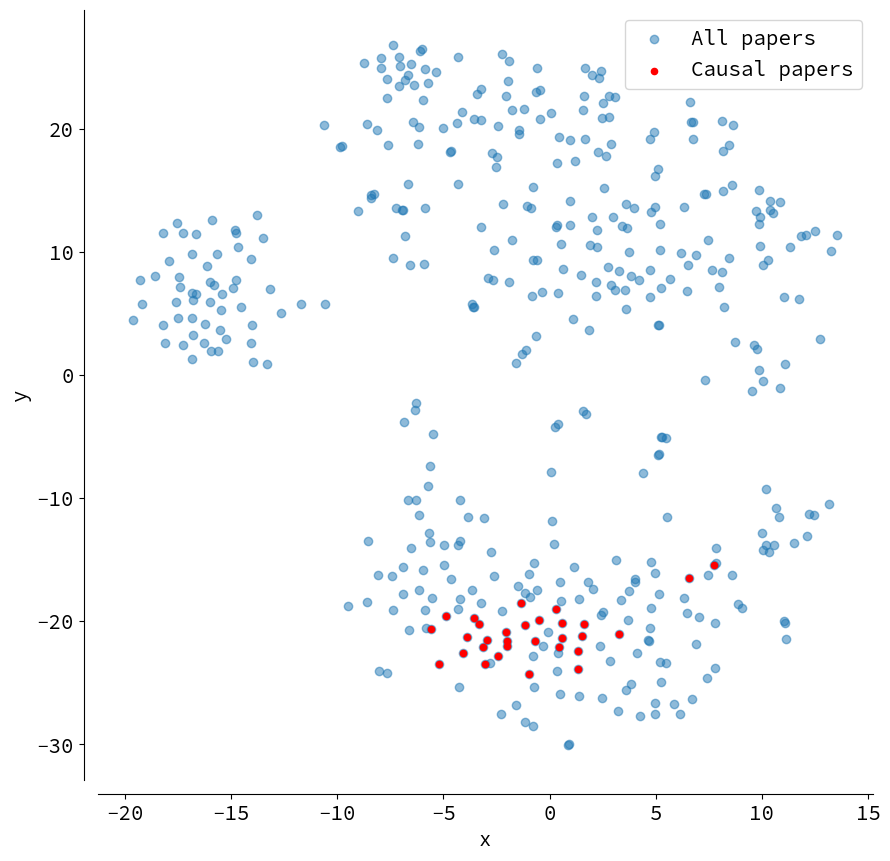

In [16]:
# Set up font and font size for plots
plt.rcParams["font.family"] = "Source Code Pro"
plt.rcParams["font.size"] = 15

# Let's redo our t-SNE plot with the QA results
fig, ax = plt.subplots(figsize=(10, 10))

top_n = 30
ax.scatter(embed_df.x, embed_df.y, alpha=0.5)
embed_df[embed_df.uuid.isin(df_search[:top_n].uuid)]
embed_df[embed_df.uuid.isin(df_search[:top_n].uuid)].plot(
    "x", "y", kind="scatter", color="red", ax=ax
)

# Add legend to plot
ax.legend(["All papers", "Causal papers"], loc="upper right")

# Remove the top and right spines from plot
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Despine the plot to remove origin
ax.spines["left"].set_position(("outward", 10))
ax.spines["bottom"].set_position(("outward", 10))


### Get methods and tables from PDFs and embbed them too!

In [17]:
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llmsherpa.readers.file_reader import LayoutPDFReader
from llama_index.vector_stores.duckdb import DuckDBVectorStore
from llama_index.core import StorageContext
from llama_index.core import Settings

Settings

paths_pdfs = list(
    Path("/mnt/drive/lit_review_data/pdfs_mortality").rglob("*.pdf")
)
pdfs_ids = [p.stem for p in paths_pdfs if p.stem in df_search[:59].uuid.values]
pdfs_ids  # Get the top-30 papers in QA search

['7bcd58f53a',
 '9e6de5af9a',
 'ccb1953770',
 'f30ef16dd5',
 'ac109f39a4',
 '9d020fa03e',
 'b69849fa06',
 '7ea41704b5',
 '6eb80e4119',
 'e2ec91f466',
 'de0cdbd0d7',
 '194461616b',
 'd348b54b95',
 'bf22813afe',
 'd5bcd9e893',
 '0bab5f18e8',
 '144a6ef658',
 'c31aaf3aff',
 'a86cadce28',
 '44c573e47c',
 '84ff990353',
 'ece586f8d9',
 '0f198ae65a',
 '7f2beb5ba6']

In [18]:
Settings

_Settings(_llm=None, _embed_model=None, _callback_manager=None, _tokenizer=None, _node_parser=None, _prompt_helper=None, _transformations=None)

In [86]:
with_pdfs = con.execute(
    "select uuid, doi, title, first_author, year from adaptation_mortality where uuid in ('"
    + "','".join(pdfs_ids)
    + "')"
).df()

In [88]:
with_pdfs.sort_values("first_author")

,uuid,doi,title,first_author,year
11,d5bcd9e893,10.1257/aer.p20151028,Convergence in Adaptation to Climate Change: E...,"Barreca, Alan",2015
23,ece586f8d9,10.1007/s10584-020-02797-0,Economic valuation of climate change–induced m...,"Botzen, W. J. W.",2020
12,a86cadce28,10.1175/jamc-d-12-0341.1,Regional Climate Projections of Extreme Heat E...,"Casati, Barbara",2013
3,0f198ae65a,10.1002/joc.6104,Anthropogenic climate change and heat effects ...,"Christidis, Nikolaos",2019
4,d348b54b95,10.3390/ijerph16030432,Effects of Extreme Temperatures on Mortality a...,"Dang, Tran",2019
16,e2ec91f466,10.1257/app.3.4.152,"Climate Change, Mortality, and Adaptation: Evi...","Deschênes, Olivier",2011
13,9d020fa03e,10.1002/wcc.211,Winter mortality in a warming climate: a reass...,"Ebi, Kristie L.",2013
5,de0cdbd0d7,10.1002/ece3.4706,Rapid adaptation to high temperatures in <i>Ch...,"Foucault, Quentin",2018
8,9e6de5af9a,10.1108/ijccsm-05-2017-0119,Do people adapt to climate change? Evidence fr...,"Korhonen, Marko",2019
21,7f2beb5ba6,10.1038/s41598-021-99757-0,Future heat adaptation and exposure among urba...,"Krummenauer, Linda",2021


### Test LlamaIndex to do cool stuff

In [59]:
path_papers = list(
    Path("/mnt/drive/lit_review_data/pdfs_mortality").rglob("*.pdf")
)

In [17]:
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llmsherpa.readers.file_reader import LayoutPDFReader

# loads BAAI/bge-small-en-v1.5
embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")

pdf_reader = LayoutPDFReader(
    "http://172.17.0.2:5001/api/parseDocument?renderFormat=all"
)

# paper_dicts = {}
# for full_paper_path in path_papers:
#     paper_base = full_paper_path.stem
#     md_json_objs = parser.get_json_result(full_paper_path)
#     json_dicts = md_json_objs[0]["pages"]
#     paper_dicts[paper_base] = {
#         "paper_path": full_paper_path,
#         "json_dicts": json_dicts,
#     }

In [70]:
doc = pdf_reader.read_pdf(str(path_papers[123]))

In [71]:
for sec in doc.sections():
    print(sec.title)
    # HTML(sec.to_html(include_children=True, recurse=True))

Khuong Dinh Van1,2*†, Lizanne Janssens1†, Sara Debecker1 and Robby Stoks1
Summary
Introduction
Materials and methods
STUDY POPULATIONS AND REARING EXPERIMENT
EXPERIMENTAL DESIGN
RESPONSE VARIABLES
STATIST ICAL ANALYSES
Results
LIFE HISTORY
Effect
FOOD INTAKE
Discussion
PHYSIOLOGY
(c)
(d)
SYNTHESIS AND APPLICATIONS
Acknowledgements
References
Supporting Information


In [67]:
HTML(doc.sections()[12].to_html(include_children=True, recurse=True))

### Marshall's papers

In [34]:
con.sql(
    """
SELECT 
hash(doi) as id,
doi,
title,
given_1 ||' '||family_1 as name,
year::int as year,
type, link
FROM read_parquet("/mnt/drive/lit_review_data/crossref_parquet_flatten/*.parquet", union_by_name=True)
where given_1 = 'Marshall' AND family_1 = 'Burke'
AND type = 'journal-article'
AND abstract IS NOT NULL
"""
)

┌──────────────────────┬─────────────────────────────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────┬────────────────┬───────┬─────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│          id          │                   doi                   │                                               title                                               │      name      │ year  │      type       │                                                                                                                                                                     link                                                                            

### How many papers in adaptation we have in the Crossref database by year?

In [2]:
duckdb.query(
    """
    SELECT title, 
    type, 
    url, 
    list_extract(list_extract(published['date-parts'], 1),1) as year 
    FROM read_parquet('/mnt/drive/crossref_april_parquet/*.parquet', union_by_name=true)
    WHERE regexp_matches(title, 'climate adaptation|adaptation to climate change')  
    AND type = 'journal-article' order by 4;
    """
)

┌────────────────────────────────────────┬─────────────────┬───────────────────────────────────────────────────┬───────┐
│                 title                  │      type       │                        url                        │ year  │
│                varchar                 │     varchar     │                      varchar                      │ int64 │
├────────────────────────────────────────┼─────────────────┼───────────────────────────────────────────────────┼───────┤
│ Cattle king a climate adaptation pio…  │ journal-article │ http://dx.doi.org/10.1071/ec12228                 │  1974 │
│ The scope for adaptation to climate …  │ journal-article │ http://dx.doi.org/10.1016/s0959-3780(98)00004-1   │  1998 │
│ Risks, opportunities and adaptation …  │ journal-article │ http://dx.doi.org/10.3354/cr011085                │  1998 │
│ Technology innovation as a strategy …  │ journal-article │ http://dx.doi.org/10.1016/s0143-6228(01)00004-2   │  2001 │
│ Book Review: Vulnerability and

In [3]:
# Try to get all the stuff we need!
adapt_papers = duckdb.query(
    """
    SELECT title, 
    container_title,
    doi, 
    url,
    family_1,
    list_extract(list_extract(published['date-parts'], 1),1) as year 
    FROM read_parquet('/mnt/drive/crossref_april_parquet/*.parquet', union_by_name=true)
    WHERE regexp_matches(title, 'climate adaptation|adaptation to climate change')  
    AND type = 'journal-article' order by 4;
    """
).to_df()

adapt_papers.head()

,title,container_title,doi,url,family_1,year
0,Human adaptation to climate change: An introdu...,American Journal of Human Biology,10.1002/ajhb.23530,http://dx.doi.org/10.1002/ajhb.23530,Pisor,2020
1,Beyond skeletal studies: A computational analy...,American Journal of Biological Anthropology,10.1002/ajpa.24932,http://dx.doi.org/10.1002/ajpa.24932,Bastir,2024
2,The spatial representation of business models ...,Business Strategy &amp; Development,10.1002/bsd2.92,http://dx.doi.org/10.1002/bsd2.92,DiBella,2019
3,Business adaptation to climate change: America...,Business Strategy and the Environment,10.1002/bse.2316,http://dx.doi.org/10.1002/bse.2316,Rivera,2019
4,A relational view of climate adaptation in the...,Business Strategy and the Environment,10.1002/bse.2375,http://dx.doi.org/10.1002/bse.2375,Canevari‐Luzardo,2019


In [9]:
duckdb.query(
    """
    SELECT 
    title, 
    type, 
    url, 
    abstract, 
    list_extract(list_extract(published['date-parts'], 1),1) as year 
    FROM read_parquet('/mnt/drive/crossref_april_parquet/*.parquet', union_by_name=true) 
    WHERE regexp_matches(title, 'climate adaptation|adaptation to climate change') AND 
    type = 'journal-article' and abstract IS NOT NULL
    ORDER by 5;
    """
)

┌──────────────────────┬─────────────────┬──────────────────────┬──────────────────────────────────────────────┬───────┐
│        title         │      type       │         url          │                   abstract                   │ year  │
│       varchar        │     varchar     │       varchar        │                   varchar                    │ int64 │
├──────────────────────┼─────────────────┼──────────────────────┼──────────────────────────────────────────────┼───────┤
│ Reducing hazard vu…  │ journal-article │ http://dx.doi.org/…  │ <jats:title>Abstract</jats:title><jats:p>O…  │  2006 │
│ Community‐based di…  │ journal-article │ http://dx.doi.org/…  │ <jats:title>Abstract</jats:title><jats:p>C…  │  2006 │
│ Local initiatives …  │ journal-article │ http://dx.doi.org/…  │ <jats:title>Abstract</jats:title><jats:p>C…  │  2006 │
│ Modeling agricultu…  │ journal-article │ http://dx.doi.org/…  │ <jats:p>An approach that integrates biophy…  │  2008 │
│ A multi-institutio…  │ journal

In [12]:
duckdb.query(
    """
    with clean as (
        SELECT list_extract(affiliation_1, 1) as first_author_affiliation,
        list_extract(list_extract(published['date-parts'], 1),1) as year
        FROM read_parquet('/mnt/drive/crossref_april_parquet_normalized/*.parquet', union_by_name=true)
        WHERE affiliation_1 IS NOT NULL
        ) SELECT first_author_affiliation, count(*) AS count 
        FROM clean 
        WHERE first_author_affiliation IS NOT NULL and year == 2020
        GROUP BY first_author_affiliation 
        ORDER by count desc;
    """
)

┌─────────────────────────────────────────────────────────────────────────────────────────┬───────┐
│                                first_author_affiliation                                 │ count │
│                                         varchar                                         │ int64 │
├─────────────────────────────────────────────────────────────────────────────────────────┼───────┤
│ University of Washington                                                                │ 37393 │
│ Department of Chemistry                                                                 │  3678 │
│ California Institute of Technology                                                      │  1110 │
│ University of Massachusets Medical School                                               │  1075 │
│ Los Alamos National Lab. (LANL), Los Alamos, NM (United States)                         │  1003 │
│ Stanford University                                                                     │   828 │


In [25]:
duckdb.query(
    """
    SELECT container_title, title, type, url, list_extract(list_extract(published['date-parts'], 1),1) as year
    FROM read_parquet('/mnt/drive/crossref_april_parquet_normalized/*.parquet', union_by_name=true)
    WHERE contains(container_title, 'development')
    and list_extract(list_extract(published['date-parts'], 1),1) == 2020
    and type = 'journal-article'
    """
)

┌──────────────────────┬──────────────────────┬─────────────────┬──────────────────────────────────────────────┬───────┐
│   container_title    │        title         │      type       │                     url                      │ year  │
│       varchar        │       varchar        │     varchar     │                   varchar                    │ int64 │
├──────────────────────┼──────────────────────┼─────────────────┼──────────────────────────────────────────────┼───────┤
│ Advances in Neurod…  │ Building Social Sk…  │ journal-article │ http://dx.doi.org/10.1007/s41252-020-00149-8 │  2020 │
│ Journal of Neurode…  │ A telehealth appro…  │ journal-article │ http://dx.doi.org/10.1186/s11689-019-9302-0  │  2020 │
│ Journal of Neurode…  │ Health comorbiditi…  │ journal-article │ http://dx.doi.org/10.1186/s11689-019-9306-9  │  2020 │
│ Advances in Neurod…  │ Mindfulness Traini…  │ journal-article │ http://dx.doi.org/10.1007/s41252-020-00148-9 │  2020 │
│ South of Russia: e…  │ Ecologi

## Semantic Scholar Tests

In [8]:
import requests
from pprint import pprint

base_url = "https://api.semanticscholar.org/datasets/v1/release/"

# Set the release id
release_id = "2024-12-24"

# Make a request to get datasets available the latest release
response = requests.get(base_url + release_id)

# Print the response data
pprint(response.json())

{'README': 'Semantic Scholar Academic Graph Datasets\n'
           '\n'
           'These datasets provide a variety of information about research '
           'papers taken from a snapshot in time of the Semantic Scholar '
           'corpus.\n'
           '\n'
           'This site is provided by The Allen Institute for Artificial '
           'Intelligence (“AI2”) as a service to the\n'
           'research community. The site is covered by AI2 Terms of Use and '
           'Privacy Policy. AI2 does not claim\n'
           'ownership of any materials on this site unless specifically '
           'identified. AI2 does not exercise editorial\n'
           'control over the contents of this site. AI2 respects the '
           'intellectual property rights of others. If\n'
           'you believe your copyright or trademark is being infringed by '
           'something on this site, please follow\n'
           'the "DMCA Notice" process set out in the Terms of Use '
           '(https:/

In [9]:
response.json()

{'release_id': '2024-12-24',
 'README': 'Semantic Scholar Academic Graph Datasets\n\nThese datasets provide a variety of information about research papers taken from a snapshot in time of the Semantic Scholar corpus.\n\nThis site is provided by The Allen Institute for Artificial Intelligence (“AI2”) as a service to the\nresearch community. The site is covered by AI2 Terms of Use and Privacy Policy. AI2 does not claim\nownership of any materials on this site unless specifically identified. AI2 does not exercise editorial\ncontrol over the contents of this site. AI2 respects the intellectual property rights of others. If\nyou believe your copyright or trademark is being infringed by something on this site, please follow\nthe "DMCA Notice" process set out in the Terms of Use (https://allenai.org/terms).\n\nSAMPLE DATA ACCESS\nSample data files can be downloaded with the following UNIX command:\n\nfor f in $(curl https://s3-us-west-2.amazonaws.com/ai2-s2ag/samples/MANIFEST.txt)\n  do curl 

In [15]:
from dotenv import load_dotenv

load_dotenv()

True

In [21]:
import requests
import os

base_url = "https://api.semanticscholar.org/datasets/v1/release/"

# This endpoint requires authentication via api key
api_key = os.getenv("S2_API_KEY")
headers = {"x-api-key": api_key}

# Set the release id
release_id = "2024-12-24"

# Define dataset name you want to download
dataset_name = "abstracts"

# Send the GET request and store the response in a variable
response = requests.get(
    base_url + release_id + "/dataset/" + dataset_name, headers=headers
)

# Process and print the response data
print(response.json())

{'message': 'Forbidden'}


In [ ]:
import requests
import json

# Specify the search term
query = '"generative ai"'

# Define the API endpoint URL
url = "http://api.semanticscholar.org/graph/v1/paper/search/bulk"

# Define the query parameters
query_params = {
    "query": '"generative ai"',
    "fields": "title,url,publicationTypes,publicationDate,openAccessPdf",
    "year": "2023-",
}


# Define headers with API key
headers = {"x-api-key": api_key}

# Send the API request
response = requests.get(url, params=query_params, headers=headers).json()